Copyright (c) 2022 Graphcore Ltd. All rights reserved.

Training GPS++ on IPUs
==========

This notebook demonstrates how to run training for the GPS++ model architecture we used for our OGB-LSC PCQM4Mv2 submission. 

The challenge is to predict the HOMO-LUMO gap [[1]](https://en.wikipedia.org/wiki/HOMO_and_LUMO) of 
organic molecules, a useful property correlated to the stability of a compound. 
Typically such values are obtained from Density Functional Theory (DFT) using HPC methods, these
simulations are expensive and time consuming to run, and the objective of the challenge is to 
use machine learning to approximate the simulation and obtain results in a fraction of the time. 

We show here a smaller model of 11 million parameters, as opposed to the 44 Million used for the top-3 result, as this will train in approximatly 4 hours and uses only 4x IPUs.

In the process of doing this we will see some of the additional features we generate from the original dataset and feed into the model.

**Requirements:**

* A Poplar SDK environment enabled (see the Getting Started guide for your IPU system or take a look at this projects README).
* Python packages installed with `pip install -r requirements.txt`

**Troubleshooting:**

* If you see an `Unexpected error` when starting the machine, refresh the page and try again.

In [1]:
%pip -q install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


This example requires building a few things:

- An optimised method to get the path lengths of a graph
- IPU optimised grouped gather scatter operaions

In [2]:
%%capture
! make -C data_utils/feature_generation
! make -C static_ops

In [1]:
%matplotlib inline

import yaml
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from matplotlib import rcParams
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from argparser import parse_dict
from data_utils.load_dataset import load_raw_dataset
from data_utils.preprocess_dataset import preprocess_dataset
from notebook_utils import predict, train
import os
from ogb.lsc import PCQM4Mv2Evaluator
from inference import format_predictions

import logging
import wandb

logging.basicConfig(level="INFO")
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['axes.labelsize'] = 14
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addStereoAnnotation = True

### Weights & Biases Logging

We use `wandb` to log training metrics, and manage training runs. 
This notebook will default to using wandb offline, to use their online tracking uncomment the following two lines, and remove the `!wandb offline` line.

In [4]:
# Uncomment these two lines if you want to log to wandb online
# !wandb login $YOUR_WANDB_API_KEY
# !wandb online

# If running without a wandb login leave this line, remove if you want to log online
!wandb offline

W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.


If running on Paperspace we will run some additional configuration steps below. If you aren't running on Paperspace, ensure you have the following environment variables set: `DATASET_DIR` - location of the dataset, `CHECKPOINT_DIR` - location of any checkpoints, `POPLAR_EXECUTABLE_CACHE_DIR` - location of any Poplar executable caches or update the paths manually in the below two cells.


In [5]:
if os.getenv("PAPERSPACE_METRIC_WORKLOAD_ID"):
    !mkdir -p /tmp/exe_cache
    !rm -rf /tmp/ogb_lsc_pcqm4mv2
    !cd /graphcore/ogb_lsc_pcqm4mv2/ && find -type d -exec mkdir -p "/tmp/ogb_lsc_pcqm4mv2/{}" \;
    !cd /graphcore/ogb_lsc_pcqm4mv2/ && find -type f -exec cp -sP "${PWD}/{}" "/tmp/ogb_lsc_pcqm4mv2/{}" \;
    os.environ["DATASET_DIR"] = "/tmp/ogb_lsc_pcqm4mv2/datasets/"
    os.environ["CHECKPOINT_DIR"] = "/tmp/ogb_lsc_pcqm4mv2/checkpoints"
    os.environ["POPLAR_EXECUTABLE_CACHE_DIR"] = "/tmp/ogb_lsc_pcqm4mv2/executables"

checkpoint_directory = os.environ.get("CHECKPOINT_DIR", ".")
dataset_directory = os.environ.get("DATASET_DIR", ".")


Lets also set a few things to enable us to use the executable caches, saving us from compiling the model.

In [6]:
executable_cache_dir = os.environ.get("POPLAR_EXECUTABLE_CACHE_DIR", ".")
os.environ["TF_POPLAR_FLAGS"] = f"--executable_cache_path='{executable_cache_dir}'"

### Loading a configuration

For this example, we will use the `GPS_PCQ_4gps_11M.yaml` configuration in the `configs` directory.

In [7]:
# Choose model
model_name = "GPS_4layer" 

# Set configs
model_dict = {"GPS_4layer": "GPS_PCQ_4gps_11M.yaml"}
cfg_path = Path("configs").joinpath(model_dict[model_name])
cfg_yaml = yaml.safe_load(cfg_path.read_text())
cfg = parse_dict(cfg_yaml)

# Set the checkpoint path for the corresponding config
sub_directory = model_dict[model_name].split(".")[0]
checkpoint_path = Path(checkpoint_directory).joinpath(f"checkpoints/{sub_directory}/model-FINAL")

# Turn off dataset caching for this notebook
cfg.dataset.save_to_cache = False 
cfg.dataset.load_from_cache = True 
cfg.dataset.cache_path = dataset_directory

# wandb setup from configuration file
if cfg.wandb:
    os.environ["WANDB_NOTEBOOK_NAME"] = "notebook_training.ipynb"
    wandb.init(entity=cfg.wandb_entity, project=cfg.wandb_project, config=cfg.as_dict())

### Predicting the HOMO-LUMO gap of molecules in the PCQM4Mv2 Dataset

First we need to load the raw dataset - containing SMILE strings [[2]](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)
and the DFT calculated HOMO-LUMO gap. 



In [8]:
print(f"Dataset: {cfg.dataset.dataset_name}")
split_mode = "original"
graph_data = load_raw_dataset(cfg.dataset.dataset_name,
                              dataset_directory,
                              cfg)

INFO:root:Extended features: True
INFO:root:Conformers: True
INFO:root:Processed Dataset ./pcqm4mv2_conformers_28features/processed/data_processed already exists


Dataset: pcqm4mv2_conformers_28features


INFO:root:Original dataset split
Getting stats for train split: 100%|██████████| 3378606/3378606 [00:07<00:00, 448161.97it/s]
INFO:root:Dataset stats for split train: {'nodes': {'max': 20, 'min': 1, 'median': 15.0, 'mean': 14.121692200866274}, 'edges': {'max': 54, 'min': 0, 'median': 30.0, 'mean': 29.06841638237782}}
Getting stats for valid split: 100%|██████████| 73545/73545 [00:00<00:00, 442676.88it/s]
INFO:root:Dataset stats for split valid: {'nodes': {'max': 51, 'min': 1, 'median': 14.0, 'mean': 14.285770616629275}, 'edges': {'max': 118, 'min': 0, 'median': 30.0, 'mean': 29.568889795363383}}
Getting stats for test-dev split: 100%|██████████| 147037/147037 [00:00<00:00, 448146.30it/s]
INFO:root:Dataset stats for split test-dev: {'nodes': {'max': 50, 'min': 1, 'median': 14.0, 'mean': 14.281344151472078}, 'edges': {'max': 116, 'min': 0, 'median': 30.0, 'mean': 29.552221549677974}}
Getting stats for test-challenge split: 100%|██████████| 147432/147432 [00:00<00:00, 452486.01it/s]
INFO:

In [9]:
smiles_df = graph_data.dataset.load_smile_strings()

Before processing the dataset let's look at some example molecules. \
We take a random index of the dataset, get the smile string, and plot the molecule.


**Feel free to run the following block multiple times to see different example molecules.**

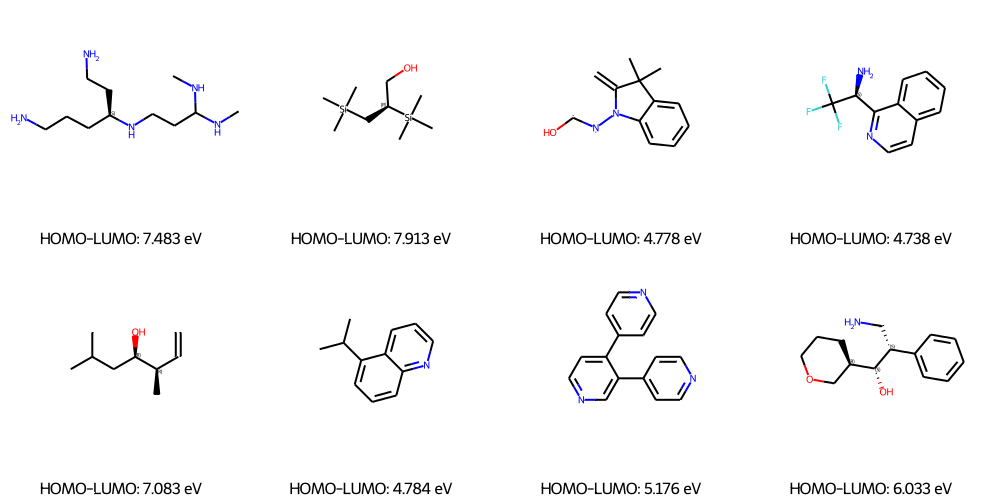

In [10]:
# Take a random index from the train dataset split
r_idx = np.random.choice(graph_data.dataset.get_idx_split()["train"], 8)
# Extract SMILES, RDKit molecular objects, ground_truth labels, and predictions for these molecules
Smiles = [smiles_df[0][r] for r in r_idx]
GT = [smiles_df[1][r] for r in r_idx]
Mols = [Chem.MolFromSmiles(r) for r in Smiles]

# Create labels
labelList = [f"HOMO-LUMO: " + str('%.3f' %gt) + " eV" for gt in zip(GT)]
# Display molecules with labels
Draw.MolsToGridImage(Mols,molsPerRow=4,legends=[label for label in labelList],
                    subImgSize=(250,250), useSVG=False)

Next we need to preprocess the dataset - this is time consuming, so instead we will load an already preprocessed dataset from the cache.

Note that if you want to play around with changing the dataset features this will take longer!

In [11]:
# With the cache this step should take ~ 5 minutes
graph_preprocessed = preprocess_dataset(dataset=graph_data,
                                        options=cfg)

Checking size of graphs against given options...: 100%|██████████| 3746620/3746620 [00:08<00:00, 442497.19it/s]
INFO:root:Preprocessing features in order: ['senders_receivers', 'bond_lengths', 'laplacian_eig', 'random_walk', 'chemical_features', 'graph_idxs', 'shortest_path_distances', 'centrality_encoding', 'atom_distance']
INFO:root:Attempting to load preprocessed dataset item senders_receivers from pcqm4mv2_conformers_28features_preprocessed/senders_receivers_053956af44241b265550cd101f5f9caa...
INFO:root:Successfully loaded preprocessed dataset item senders_receivers from pcqm4mv2_conformers_28features_preprocessed/senders_receivers_053956af44241b265550cd101f5f9caa
INFO:root:Attempting to load preprocessed dataset item bond_lengths from pcqm4mv2_conformers_28features_preprocessed/bond_lengths_053956af44241b265550cd101f5f9caa...
INFO:root:Successfully loaded preprocessed dataset item bond_lengths from pcqm4mv2_conformers_28features_preprocessed/bond_lengths_053956af44241b265550cd101f

### Model Architecuture 



The GPS++ model is a hybrid message passing neural network and transformer, which builds on the previous work of the General, Powerful, Scalable (GPS) framework [3](https://arxiv.org/abs/2205.12454).

The key advantage of this architecture is that by combining the large and expressive message passing module with a biased self-attention layer local inductive biases can be exploited while still allowing efficient global communication. 

Additionaly we incorperate grouped input masking, and use the available 3D information as an auxillary denoising objective during training. 

The GPS layers compose the majority (> 99%) of the model parameters, and below is a diagram showing how the MPNN and Self-Attention modules interact with each other.

For further details on the architecture and training process look at our paper.

Here you can see the main GPS++ processing block - showing global, edge and node features, as well as attention biases passing through each GPS layer.



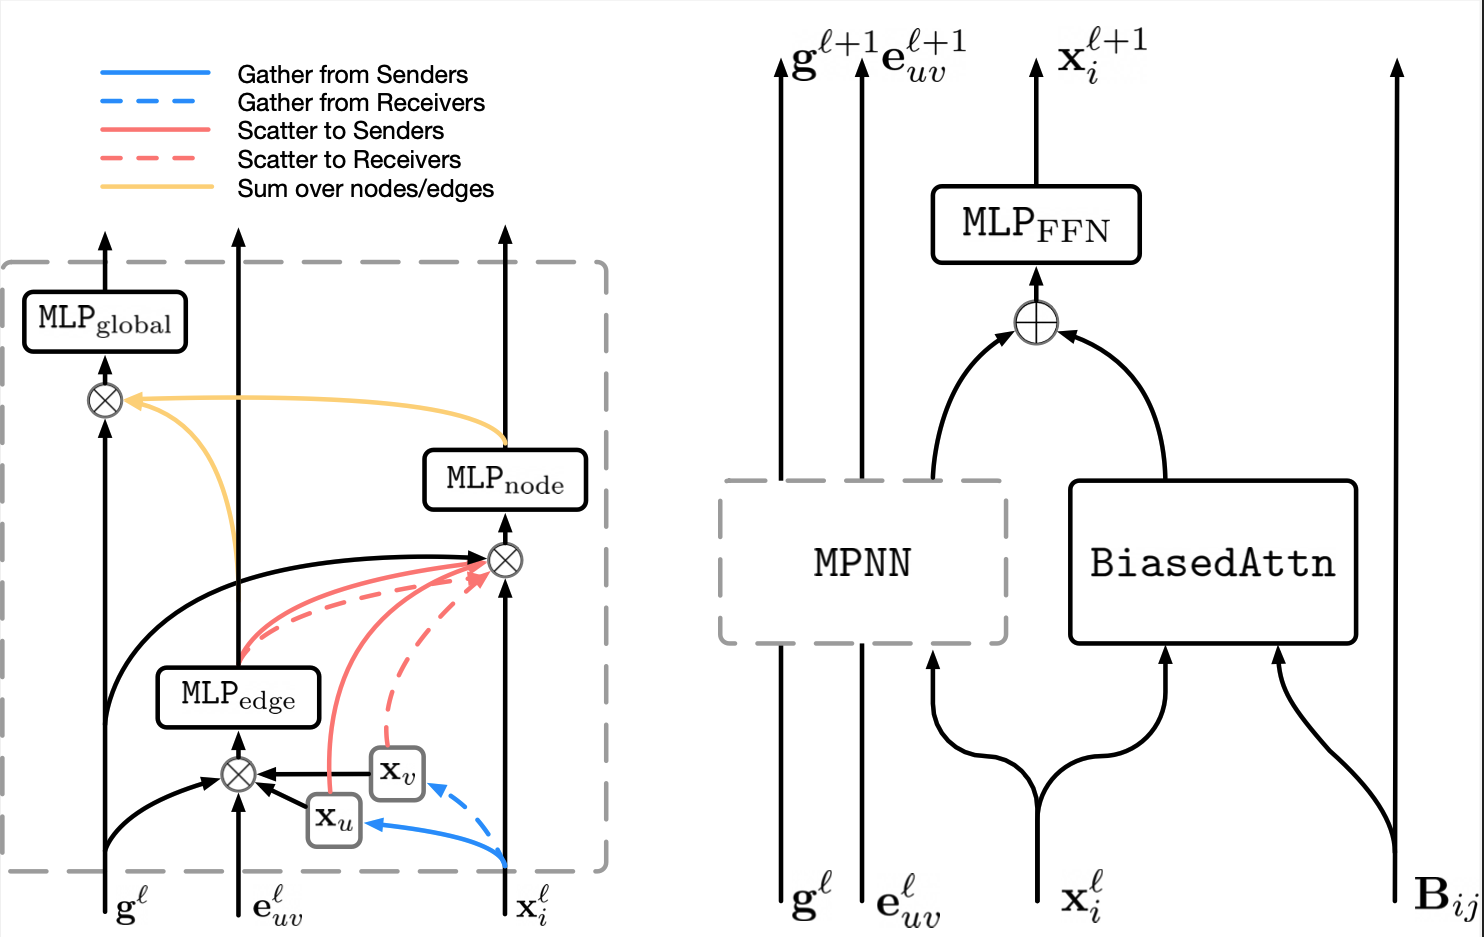

In [2]:
Image("OGB_paper_diagram.png", width=800)

## Training

Now we are ready to run on the IPU. We have wrapped this functionality in a single function for simplicity. We encourage you to check the contents of this function in `notebook_utils.py`.

Some key details here are:
* The main regression loss is measured as the Mean Absolute Error (L1 loss) between predicted and target HOMO-LUMO gaps
* With the original dataset split we loop through the ~ 3.3M molecules in the training dataset each epoch
* The 11 Million parameter model is pipelined over 4x IPUs

Now finally let's run the training of our GPS++ model.


In the interest of time, we will set the number of training epochs to 10, taking approximately 40 minutes. Feel free to train for more epochs. As a guide training for the full 100 epochs takes approximately 4 hours.

In [13]:
cfg.model.epochs = 10
checkpoint_paths = train(graph_preprocessed, cfg)

INFO:root:Model weights will be saved to /tmp/tmpvtbn03gl
INFO:root:Dataset has 3378606 elements
INFO:root:Doing streaming packing
INFO:root:Packing dataset...
100%|██████████| 3378606/3378606 [04:10<00:00, 13506.00it/s]
INFO:root:Finished packing dataset.
INFO:root:Packing stats: {'avg_pack': {'nodes': 51.118695023303154, 'edges': 105.22389885894894, 'graphs': 3.6198703594578667}, 'max_pack': {'nodes': 60, 'edges': 120, 'graphs': 6}, 'pack_std': {'nodes': 5.05230481995295, 'edges': 9.77582687764277, 'graphs': 0.5369691518630219}, 'pack_limiter': {'nodes': 0.8350736593989393, 'edges': 0.9943772432635132, 'graphs': 0.0}, 'pack_efficiency': {'nodes': 0.8519782503883859, 'edges': 0.8768658238245746, 'graphs': 0.45248379493223334, 'total': 0.8692960987969729}, 'graphs_per_epoch': 3378606, 'packs_per_epoch': 933350, 'average_global_batch_size': 0.0, 'micro_batch_size': 6, 'GA_factor': 0}
INFO:root:Setting gradient_accumulation_factor to 10
INFO:root:Dataset stats: {'avg_pack': {'nodes': 51.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f42b2563368> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:root:Features requested for grouped masking: {'ogb_bond_lengths', 'atom_distances', 'shortest_path_distances'}WARNING:tensorflow:AutoGraph could not transform <bound method Socket.send of <zmq.Socket(zmq.PUSH) at 0x7f42b47485f8>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f42b2563368> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f42b2563368> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert



INFO:root:Missing features: set()
INFO:root:Steps per epoch: 155520
INFO:root:Steps per execution per replica: 38880
INFO:root:Model inputs: {'node_feat': <KerasTensor: shape=(6, 61, 11) dtype=int32 (created by layer 'node_feat')>, 'edge_feat': <KerasTensor: shape=(6, 121, 3) dtype=int32 (created by layer 'edge_feat')>, 'receivers': <KerasTensor: shape=(6, 121) dtype=int32 (created by layer 'receivers')>, 'senders': <KerasTensor: shape=(6, 121) dtype=int32 (created by layer 'senders')>, 'node_graph_idx': <KerasTensor: shape=(6, 61) dtype=int32 (created by layer 'node_graph_idx')>, 'edge_graph_idx': <KerasTensor: shape=(6, 121) dtype=int32 (created by layer 'edge_graph_idx')>, 'lap_eig_vals': <KerasTensor: shape=(6, 61, 7, 1) dtype=float32 (created by layer 'lap_eig_vals')>, 'lap_eig_vecs': <KerasTensor: shape=(6, 61, 7) dtype=float32 (created by layer 'lap_eig_vecs')>, 'random_walk_landing_probs': <KerasTensor: shape=(6, 61, 16) dtype=float32 (created by layer 'random_walk_landing_pro

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom_distances (InputLayer)     [(6, 61, 61)]        0                                            
__________________________________________________________________________________________________
centrality_encoding (InputLayer [(6, 61)]            0                                            
__________________________________________________________________________________________________
edge_feat (InputLayer)          [(6, 121, 3)]        0                                            
__________________________________________________________________________________________________
edge_graph_idx (InputLayer)     [(6, 121)]           0                                            
______________________________________________________________________________________________

INFO:tensorflow:Training is distributed and accumulating 10 batches per optimizer step across 4 replicas, your effective batch size is 240.


INFO:tensorflow:Training is distributed and accumulating 10 batches per optimizer step across 4 replicas, your effective batch size is 240.


Epoch 1/10


/localdata/samuelm/public_examples/applications/tensorflow2/bert/ENVs/poplar_sdk-ubuntu_18_04-3.0.0+1145-1b114aac3a/3.0.0+1145_tf2/lib/python3.6/site-packages/keras/engine/functional.py:589: UserWarning:

Input dict contained keys ['node_mask', 'edge_mask'] which did not match any model input. They will be ignored by the model.

INFO:root:Processed 0 packs (0%)
INFO:root:Processed 186670 packs (20%)
INFO:root:Processed 373340 packs (40%)
INFO:root:Processed 560010 packs (60%)
INFO:root:Processed 746680 packs (80%)
INFO:root:Processed 933349 packs (100%)


38880/38880 [==============================] - 458s 12ms/step - loss: 76.6656 - Main_loss: 8.6871 - Noisy_Nodes_loss: 28.4333 - Noisy_Edges_loss: 28.2154 - Main_MAE: 10.2379


INFO:absl:
Throughput: 7376.18 graphs/sec


Epoch 2/10
38880/38880 [==============================] - 151s 4ms/step - loss: 4.1518 - Main_loss: 3.4779 - Noisy_Nodes_loss: 0.4304 - Noisy_Edges_loss: 0.1312 - Main_MAE: 4.0988


INFO:absl:
Throughput: 22398.14 graphs/sec


Epoch 3/10
38880/38880 [==============================] - 149s 4ms/step - loss: 2.8662 - Main_loss: 2.7615 - Noisy_Nodes_loss: 0.0574 - Noisy_Edges_loss: 0.0298 - Main_MAE: 3.2544


INFO:absl:
Throughput: 22658.24 graphs/sec


Epoch 4/10
38880/38880 [==============================] - 149s 4ms/step - loss: 2.4444 - Main_loss: 2.3890 - Noisy_Nodes_loss: 0.0296 - Noisy_Edges_loss: 0.0165 - Main_MAE: 2.8155


INFO:absl:
Throughput: 22604.18 graphs/sec


Epoch 5/10
38880/38880 [==============================] - 151s 4ms/step - loss: 2.1561 - Main_loss: 2.1209 - Noisy_Nodes_loss: 0.0177 - Noisy_Edges_loss: 0.0117 - Main_MAE: 2.4995


INFO:absl:
Throughput: 22379.44 graphs/sec


Epoch 6/10
38880/38880 [==============================] - 151s 4ms/step - loss: 1.9258 - Main_loss: 1.8989 - Noisy_Nodes_loss: 0.0133 - Noisy_Edges_loss: 0.0090 - Main_MAE: 2.2379


INFO:absl:
Throughput: 22420.09 graphs/sec


Epoch 7/10
38880/38880 [==============================] - 150s 4ms/step - loss: 1.7579 - Main_loss: 1.7350 - Noisy_Nodes_loss: 0.0115 - Noisy_Edges_loss: 0.0076 - Main_MAE: 2.0447


INFO:absl:
Throughput: 22525.47 graphs/sec


Epoch 8/10
38880/38880 [==============================] - 149s 4ms/step - loss: 1.6465 - Main_loss: 1.6262 - Noisy_Nodes_loss: 0.0104 - Noisy_Edges_loss: 0.0065 - Main_MAE: 1.9165


INFO:absl:
Throughput: 22612.58 graphs/sec


Epoch 9/10
38880/38880 [==============================] - 151s 4ms/step - loss: 1.5595 - Main_loss: 1.5413 - Noisy_Nodes_loss: 0.0096 - Noisy_Edges_loss: 0.0057 - Main_MAE: 1.8164


INFO:absl:
Throughput: 22434.94 graphs/sec


Epoch 10/10
38880/38880 [==============================] - 151s 4ms/step - loss: 1.4958 - Main_loss: 1.4786 - Noisy_Nodes_loss: 0.0093 - Noisy_Edges_loss: 0.0050 - Main_MAE: 1.7425


INFO:absl:
Throughput: 22444.23 graphs/sec
INFO:root:Saving model weights from /tmp/tmpvtbn03gl/model-FINAL to wandb...
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 2 files into the W&B run directory, call wandb.save again to sync new files.


(NOTE: The notebook has been provided with the training run for 10 epochs only. If you want to run the full training this will take about 4 hours.)

### Predictions on validation dataset split

Now lets get predictions on the validation dataset split.

In [14]:
predictions, ground_truth = predict(graph_data, checkpoint_paths["FINAL"], "valid", cfg)

Creating input specification...
Configuring the IPUs...


INFO:root:Dataset has 73545 elements
INFO:root:Doing streaming packing
INFO:root:Packing dataset...


Creating TensorFlow dataset from preprocessed dataset...


100%|██████████| 73545/73545 [00:05<00:00, 13886.87it/s]
INFO:root:Finished packing dataset.
INFO:root:Packing stats: {'avg_pack': {'nodes': 50.15260871640651, 'edges': 103.80657787961239, 'graphs': 3.510668767005585}, 'max_pack': {'nodes': 60, 'edges': 120, 'graphs': 8}, 'pack_std': {'nodes': 5.606084906346487, 'edges': 10.61370506886963, 'graphs': 0.8781526683661707}, 'pack_limiter': {'nodes': 0.8344551052556208, 'edges': 0.9793784906200773, 'graphs': 0.0009546995083297532}, 'pack_efficiency': {'nodes': 0.8358768119401085, 'edges': 0.8650548156634366, 'graphs': 0.43883359587569815, 'total': 0.8561281027404359}, 'graphs_per_epoch': 73545, 'packs_per_epoch': 20949, 'average_global_batch_size': 842.5605040813405, 'micro_batch_size': 6, 'GA_factor': 10}
INFO:root:Features requested for grouped masking: {'ogb_bond_lengths', 'atom_distances', 'shortest_path_distances'}
INFO:root:Missing features: set()
INFO:root:Model inputs: {'node_feat': <KerasTensor: shape=(6, 61, 11) dtype=int32 (creat

Constructing the model...
Loading the checkpoint from /tmp/tmpvtbn03gl/model-FINAL...
Running `model.predict` to generate predictions...


INFO:root:Processed 0 packs (0%)
INFO:root:Processed 4189 packs (20%)
INFO:root:Processed 8378 packs (40%)
INFO:root:Processed 12567 packs (60%)
INFO:root:Processed 16756 packs (80%)
INFO:root:Processed 20945 packs (100%)
INFO:root:Processed 20948 packs (100%)


Lets take a look at the mean, variance and histogram of the predictions.

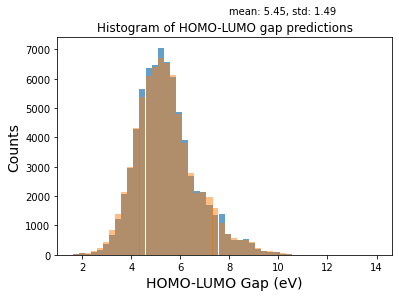

In [15]:
mean = predictions.astype(float).mean()
std = predictions.astype(float).var()

bins = plt.hist(predictions, 50, alpha = 0.7, label = 'Predictions')[1]
plt.hist(ground_truth, bins, alpha = 0.5, label = 'Ground truth')
plt.xlabel("HOMO-LUMO Gap (eV)")
plt.ylabel("Counts")
plt.title("Histogram of HOMO-LUMO gap predictions")
plt.text(8, 8200, f'mean: {mean:.2f}, std: {std:.2f}')
plt.show()

Finally we can evaluate the predicted HOMO-LUMO gaps with the ground truth values. 

In [16]:

evaluator = PCQM4Mv2Evaluator()
formatted_predictions = format_predictions(dataset_name=cfg.dataset.dataset_name,
                                           y_true=ground_truth,
                                           y_pred=predictions)
# we will use the official evaluator from the OGB repo
result = evaluator.eval(formatted_predictions)["mae"]
print(" "+"="*50+"\n",
      f"\U00002B50 Result: Validation MAE = {result:.4f}\n",
      "="*50+"\n",
      )

 ⭐ Result: Validation MAE = 0.1656



Note here that the MAE is still relatively high as this example only shows training for 10 epochs.

The small GPS++ 11M parameter model trained for the full 100 epochs should reach an MAE of ~ 0.090 

In [17]:
wandb.finish()

Main_MAE,█▃▂▂▂▁▁▁▁▁
Main_loss,█▃▂▂▂▁▁▁▁▁
Noisy_Edges_loss,█▁▁▁▁▁▁▁▁▁
Noisy_Nodes_loss,█▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
parameter size (MiB),▁
parameters,▁
throughput,▁█████████
Main_MAE,1.74253
Main_loss,1.4786


### Follow up tasks

Some additional tasks to explore include:
* Try increasing the number of epochs to train the model over to achieve a better final validation MAE
* Try the inference notebook if you haven't already
* Read the paper on GPS++ for further details about the implementation